In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from resources import load_data, custom_k_fold_split, standardize_data
from tqdm import tqdm

def custom_F1_weighted(y_test, predictions):
    return f1_score(y_test, predictions, average='weighted', zero_division=0)

def custom_mean_squared_error(y_test, predictions):
    return np.mean((y_test-predictions)**2)

def fit_and_evaluate_model(model, X, y, metric: callable = custom_F1_weighted):
    metric_ = []
    for fold in custom_k_fold_split(X, y, method='individual'):
        X_train, X_test, y_train, y_test = fold
        X_train, X_test = standardize_data(X_train, X_test)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        metric_.append(metric(y_test, predictions))

    return metric_

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0).reset_index(drop=True)
        df.sample(n_samples, replace=True).to_csv('data/HR_data_bootstrapped.csv', index=False)
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def no_resample():
    X, y = load_data('data/HR_data.csv')
    return [(X, y)]

def bootstrap_evaluation(model, sets, metric: callable = custom_F1_weighted):
    bootstrap_results = {
        'metric': []
    }

    for X, y in tqdm(sets, desc=str(model).split('.')[-1].split("\'")[0]):
        model_ = model()
        metric_ = fit_and_evaluate_model(model_, X, y, metric=metric)
        bootstrap_results['metric'].append(metric_)

    list_of_metrics = []           
    for round in bootstrap_results['metric']:
        for val in round:
            list_of_metrics.append(val)
    return list_of_metrics

Baseline: 100%|██████████| 20/20 [00:01<00:00, 16.02it/s]


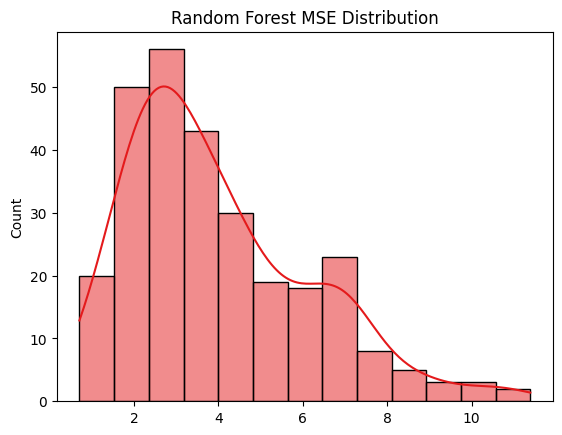

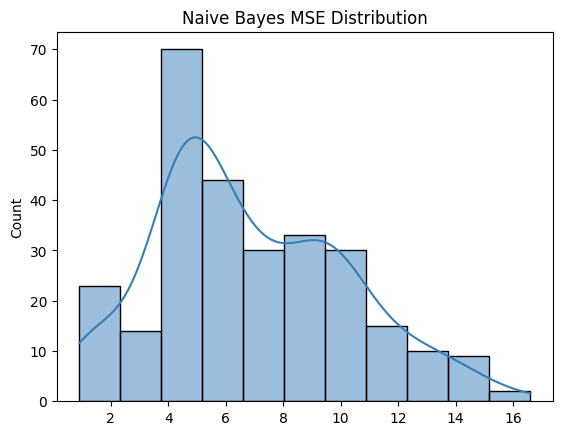

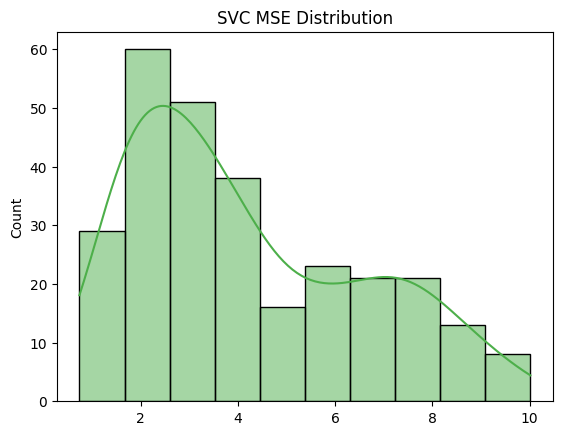

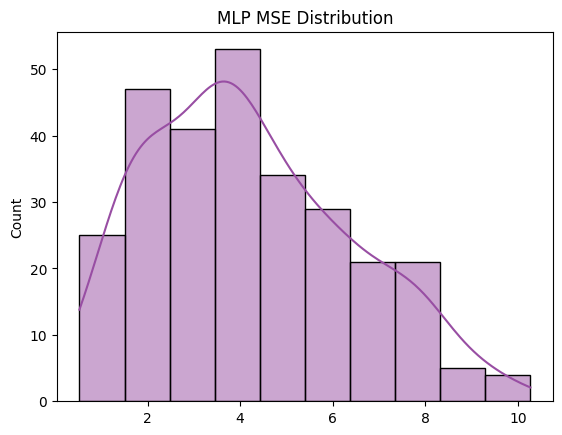

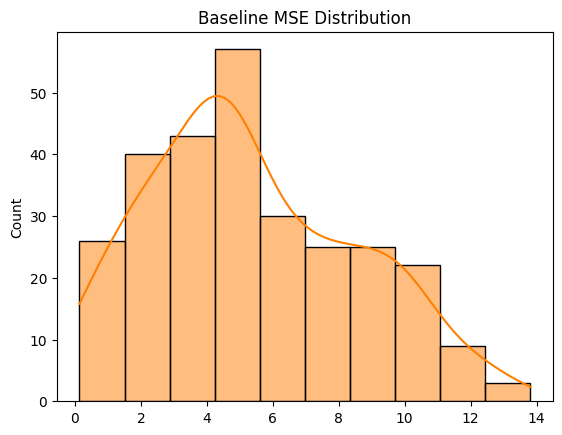

Random Forest Naive Bayes SVC MLP Baseline
3.9880383467556166 6.874256163295383 4.190242823958697 4.215661913693774 5.3725703374540075


In [11]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

_METRIC_ = custom_mean_squared_error
_METRIC_NAME_ = 'MSE'

data = custom_resample(20, 1000)

acc = bootstrap_evaluation(RandomForestClassifier, data, metric=_METRIC_)
nb_acc = bootstrap_evaluation(GaussianNB, data, metric=_METRIC_)
svc_acc = bootstrap_evaluation(SVC, data, metric=_METRIC_)
nn_acc = bootstrap_evaluation(lambda: MLPClassifier(max_iter=1000), data, metric=_METRIC_)
base_acc = bootstrap_evaluation(Baseline, data, metric=_METRIC_)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
metrics = [acc, nb_acc, svc_acc, nn_acc, base_acc]

import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('Set1', n_colors=5)
for model, metric, color in zip(models, metrics, colors):
    sns.histplot(metric, color=color, kde=True, label=model)
    plt.title(f'{model} {_METRIC_NAME_ } Distribution')
    plt.savefig(f'plots/{model}_{_METRIC_NAME_}_dist.png')
    plt.show()

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))

import pickle
for model, metric in zip(models, metrics):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(metric, f)

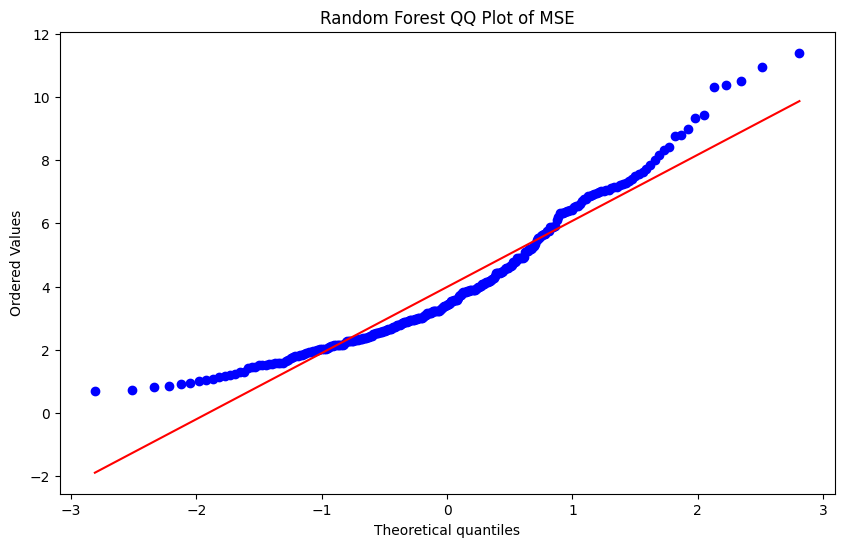

Shapiro-Wilk Test Statistic: 0.9294602449917515
Shapiro-Wilk Test p-value: 2.8755626711900977e-10
The data is not normally distributed (reject H0)


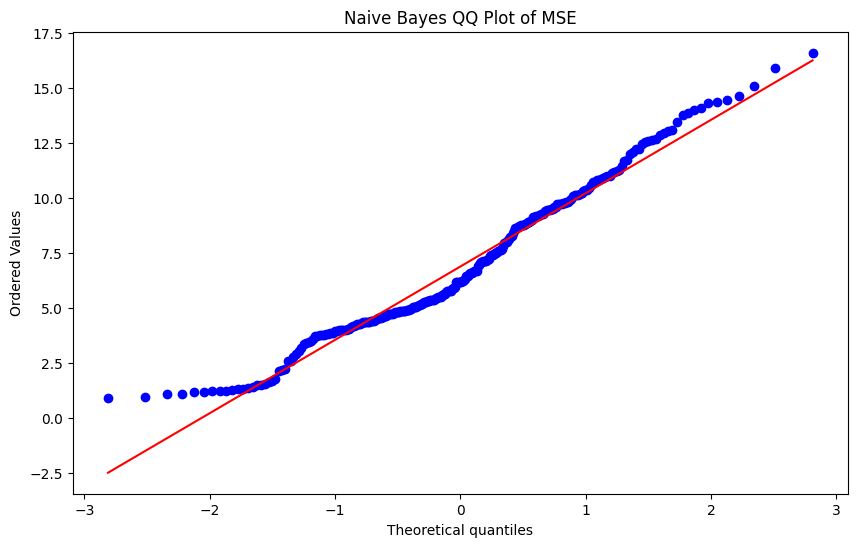

Shapiro-Wilk Test Statistic: 0.9698739376442568
Shapiro-Wilk Test p-value: 1.2958341331590032e-05
The data is not normally distributed (reject H0)


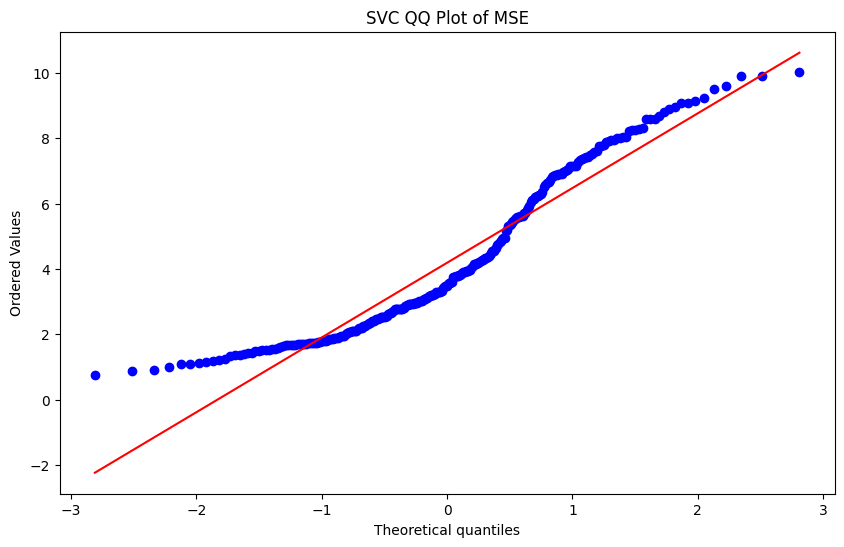

Shapiro-Wilk Test Statistic: 0.9212970274514724
Shapiro-Wilk Test p-value: 5.472245010337045e-11
The data is not normally distributed (reject H0)


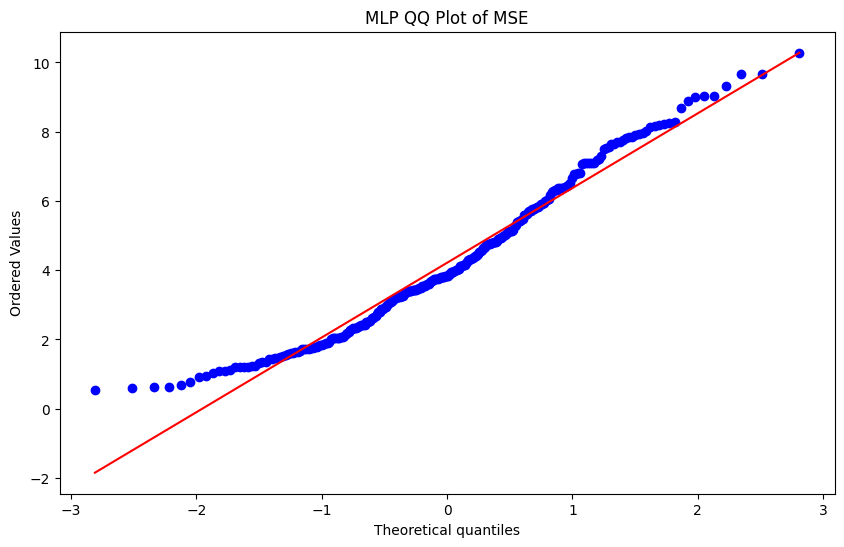

Shapiro-Wilk Test Statistic: 0.9666342397574149
Shapiro-Wilk Test p-value: 4.381861012425928e-06
The data is not normally distributed (reject H0)


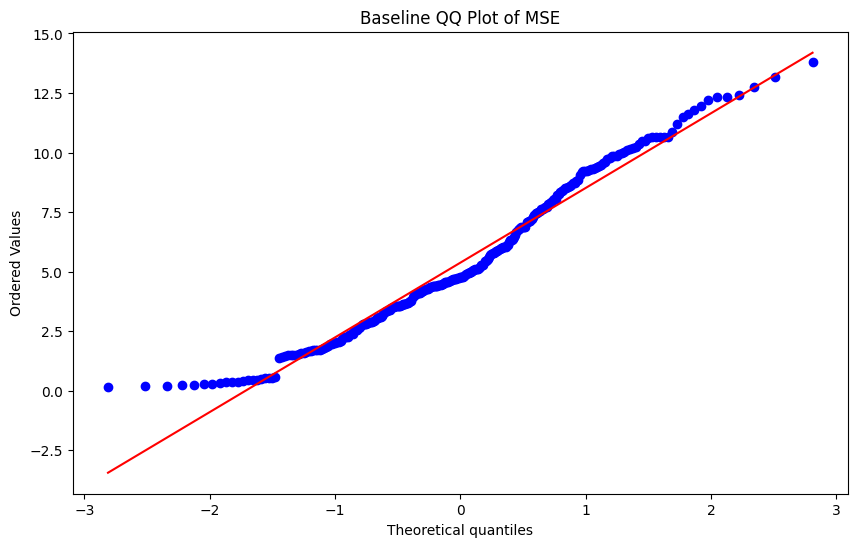

Shapiro-Wilk Test Statistic: 0.9681610956156346
Shapiro-Wilk Test p-value: 7.25372300969069e-06
The data is not normally distributed (reject H0)


,Model,Shapiro-Wilk Test p-value
0,Random Forest,2.875563e-10
1,Naive Bayes,1.295834e-05
2,SVC,5.472245e-11
3,MLP,4.381861e-06
4,Baseline,7.253723e-06


In [22]:
from scipy import stats

shapiro_results = []

for model, metric in zip(models, metrics):
    # QQ Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(metric, dist="norm", plot=plt)
    plt.title(f"{model} QQ Plot of {_METRIC_NAME_ }")
    plt.savefig(f'plots/{model}_qqplot.png')
    plt.show()

    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(metric)
    print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
    print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

    # Interpretation
    if shapiro_test.pvalue > 0.05:
        print("The data is normally distributed (fail to reject H0)")
    else:
        print("The data is not normally distributed (reject H0)")

    shapiro_results.append({
        'Model': model,
        'Shapiro-Wilk Test p-value': shapiro_test.pvalue
    })
shapiro_df = pd.DataFrame(shapiro_results)
with open('tables/shapiro.txt', 'w') as f:
    f.write(shapiro_df.to_latex())
shapiro_df

In [23]:
from scipy.stats import kruskal

# Example accuracies from three models


# Kruskal-Wallis H Test
kruskal_test = kruskal(*metrics)
print("Kruskal-Wallis H Test Statistic:", kruskal_test.statistic)
print("Kruskal-Wallis H Test p-value:", kruskal_test.pvalue)

# Interpretation
if kruskal_test.pvalue > 0.05:
    print("No significant difference between the models (fail to reject H0)")
else:
    print("Significant difference between the models (reject H0)")


Kruskal-Wallis H Test Statistic: 163.50589013364493
Kruskal-Wallis H Test p-value: 2.5877989768633315e-34
Significant difference between the models (reject H0)


In [24]:
from scipy.stats import wilcoxon

p_val_matrix = np.zeros((5, 5))

for model, metric in zip(models, metrics):

    for model2, metric2 in zip(models, metrics):
        if model == model2:
            continue

        print(f"Comparing {model} and {model2}")

        # Wilcoxon Signed-Rank Test
        wilcoxon_test = wilcoxon(metric, metric2)
        print("Wilcoxon Test Statistic:", wilcoxon_test.statistic)
        print("Wilcoxon Test p-value:", wilcoxon_test.pvalue)

        # Interpretation
        if wilcoxon_test.pvalue > 0.05:
            print("No significant difference between the two models (fail to reject H0)")
        else:
            print("Significant difference between the two models (reject H0)")
        print('\n')
        p_val_matrix[models.index(model), models.index(model2)] = wilcoxon_test.pvalue


Comparing Random Forest and Naive Bayes
Wilcoxon Test Statistic: 5735.0
Wilcoxon Test p-value: 9.096070431854982e-25
Significant difference between the two models (reject H0)


Comparing Random Forest and SVC
Wilcoxon Test Statistic: 16761.0
Wilcoxon Test p-value: 0.04009429635342544
Significant difference between the two models (reject H0)


Comparing Random Forest and MLP
Wilcoxon Test Statistic: 16421.0
Wilcoxon Test p-value: 0.026878158365597593
Significant difference between the two models (reject H0)


Comparing Random Forest and Baseline
Wilcoxon Test Statistic: 9749.0
Wilcoxon Test p-value: 2.563133608763125e-13
Significant difference between the two models (reject H0)


Comparing Naive Bayes and Random Forest
Wilcoxon Test Statistic: 5735.0
Wilcoxon Test p-value: 9.096070431854982e-25
Significant difference between the two models (reject H0)


Comparing Naive Bayes and SVC
Wilcoxon Test Statistic: 7274.0
Wilcoxon Test p-value: 6.211981322686852e-20
Significant difference betwe

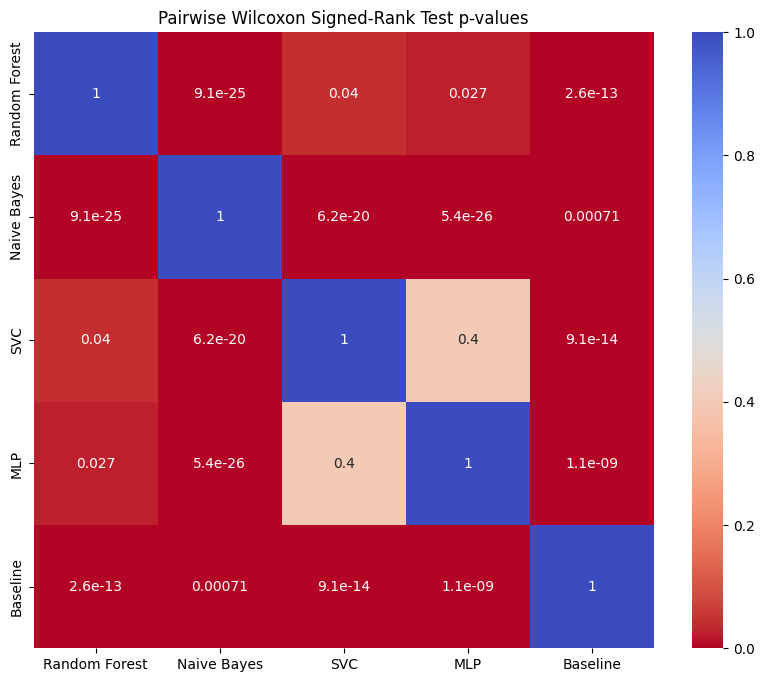

In [15]:
# Initialize p-value matrix
p_val_matrix = np.ones((len(models), len(models))) 

# Compute pairwise Wilcoxon Signed-Rank Test
for i, metric in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i == j:
            continue
        wilcoxon_test = wilcoxon(metric, metric2)
        p_val_matrix[i, j] = wilcoxon_test.pvalue

# Visualize p-value matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_val_matrix, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True)
plt.title('Pairwise Wilcoxon Signed-Rank Test p-values')
plt.savefig('plots/pairwise_wilcoxon_pvalues.png')
plt.show()

In [25]:
mean_metrics = [np.mean(m) for m in metrics]
std_metrics = [np.std(m) for m in metrics]
df = pd.DataFrame(
    np.array([mean_metrics, std_metrics]).T, index=models, columns=[f'Mean {_METRIC_NAME_ }', 'Standard Deviation']
    )
df

,Mean MSE,Standard Deviation
Random Forest,3.988038,2.148523
Naive Bayes,6.874256,3.355040
SVC,4.190243,2.358434
MLP,4.215662,2.173511
Baseline,5.372570,3.157501


Model: Random Forest
95% Confidence Interval: [3.741, 4.247]


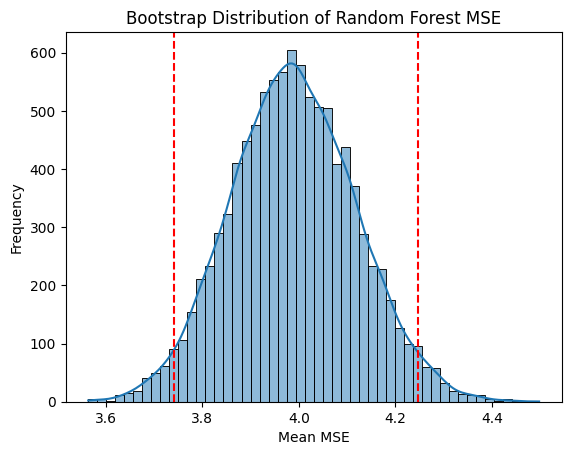

C:\Users\pvest\AppData\Local\Temp\ipykernel_9860\830139601.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ci_df = pd.concat([ci_df, confidence_intervals])


Model: Naive Bayes
95% Confidence Interval: [6.493, 7.269]


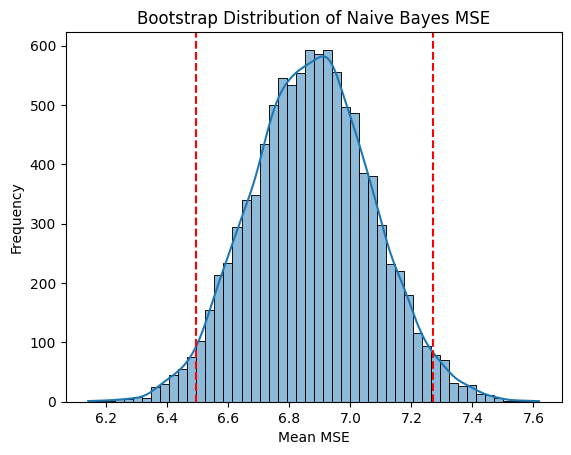

Model: SVC
95% Confidence Interval: [3.924, 4.468]


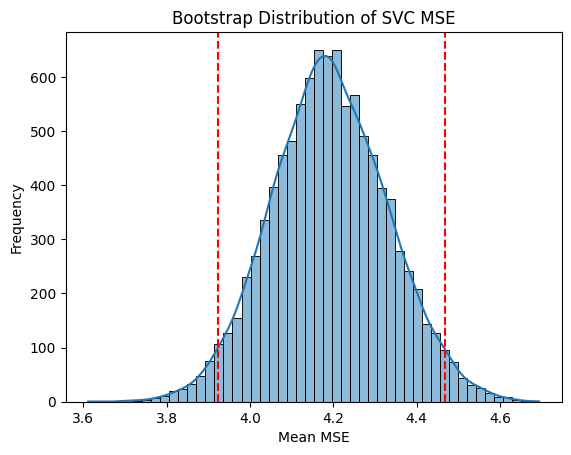

Model: MLP
95% Confidence Interval: [3.964, 4.474]


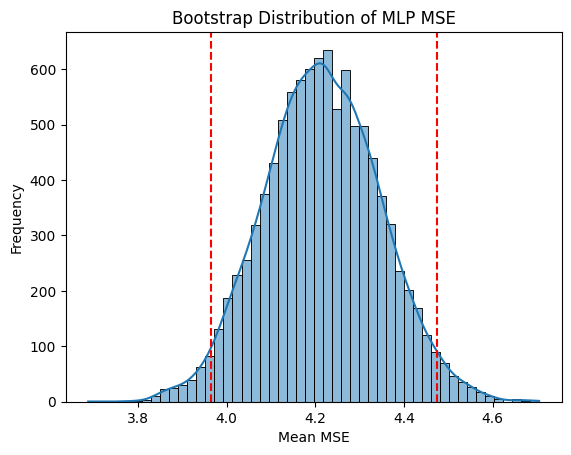

Model: Baseline
95% Confidence Interval: [5.005, 5.733]


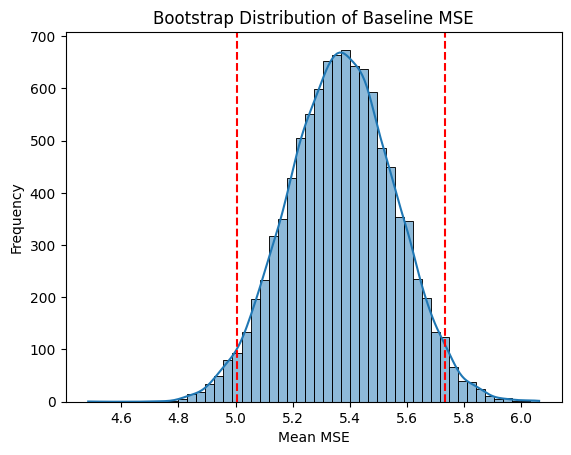

,Lower Bound,Upper Bound,Mean,Standard Deviation
Model,,,,
Naive Bayes,6.492516,7.269418,6.874256,3.355040
Baseline,5.005156,5.733244,5.372570,3.157501
MLP,3.963880,4.474293,4.215662,2.173511
SVC,3.923513,4.467940,4.190243,2.358434
Random Forest,3.741145,4.247190,3.988038,2.148523


In [26]:
ci_df = pd.DataFrame(columns=['Model', 'Lower Bound', 'Upper Bound', 'Mean', 'Standard Deviation'])

for metric, model in zip(metrics, models):
    ## Number of bootstrap samples
    n_bootstraps = 10_000
    bootstrapped_accuracies = []

    # Perform bootstrap sampling
    for _ in range(n_bootstraps):
        bootstrapped_sample = np.random.choice(metric, size=len(metric), replace=True)
        bootstrapped_accuracies.append(np.mean(bootstrapped_sample))

    # Calculate confidence intervals
    alpha = 0.95
    lower_bound = np.percentile(bootstrapped_accuracies, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_accuracies, (1 + alpha) / 2 * 100)

    # Print confidence intervals
    print(f"Model: {model}")
    print(f"95% Confidence Interval: [{lower_bound:.3f}, {upper_bound:.3f}]")

    # Visualization of the bootstrap distribution and confidence interval
    sns.histplot(bootstrapped_accuracies, bins=50, kde=True)
    plt.axvline(lower_bound, color='red', linestyle='--')
    plt.axvline(upper_bound, color='red', linestyle='--')
    plt.title(f'Bootstrap Distribution of {model} {_METRIC_NAME_ }')
    plt.xlabel(f'Mean {_METRIC_NAME_ }')
    plt.ylabel('Frequency')
    plt.show()

    confidence_intervals = pd.DataFrame({
        'Model': [model],
        'Lower Bound': [lower_bound],
        'Upper Bound': [upper_bound],
        'Mean': [np.mean(metric)],
        'Standard Deviation': [np.std(metric)]
    })

    ci_df = pd.concat([ci_df, confidence_intervals])



ci_df = ci_df.set_index('Model')

ci_df = ci_df.sort_values(by='Mean', ascending=False)
with open('tables/conf_int.txt', 'w') as f:
    f.write(ci_df.to_latex())
ci_df